### OIS-200 Preprocessing
This demo will show a standard pipeline of OIS 200 captured data, after this code, you can get affined dR/R series of data.   
Demo data was located at 'D:\ZR\_Data_Temp\Ois200_Data\Full_Demo'    
#### Steps are as Follows:    
1. Transfer .bin file into python-readable format
2. Time-course bin, down sample series into freq required.
3. Project series into standard space.
4. Filter(0.005-0.5Hz), generate dR/R and Z matrix.
5. Get data matrix of all brain area. Chamber mask, is important for it.
___

In [1]:
# import and basic path part
import Common_Functions as cf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tqdm import tqdm
import pandas as pd
from Brain_Atlas.Atlas_Mask import Mask_Generator
from OI_Functions.OIS_Preprocessing import Single_Folder_Processor # this function is standard bin transformer.

datafolder = r'D:\ZR\_Data_Temp\Ois200_Data\Full_Demo\Niid_Type'



___
Step1, you need only this line to transfer OIS data into .bin file.
Make sure you have files in folder:
1. img.bin file
2. ai.bin file
3. info.txt (this file shows the capture details and very important for codes to know what happened.)    

Processing is quite slow, so just be patient.    
If multiple channels are captured together, mutiple .npy files will be returned.

In [2]:
Single_Folder_Processor(datafolder,subfolder='Preprocessed',save_format='python',keepna=False)
# keepna parameter will maintain lost frame as 0, otherwise these frames are filled with previous frame.

# then we load the pre-processed frame.
wp = r'D:\ZR\_Data_Temp\Ois200_Data\Full_Demo\Niid_Type\Preprocessed'
raw_r_series = np.load(cf.join(wp,'Red.npy'))
print(raw_r_series.shape)

Channel Num:12, fps :10000 Hz.
Series Capture Time: 3604.0s
Graph Resolution: 256 x 256 .
Graph Number: 108082, in 1 channels.
(108082, 256, 256)


___
- Step2: bin graph.    
Check the info.txt file for fps you capture, and we usually bin into 4 or 5Hz.    
    

(18013, 256, 256)


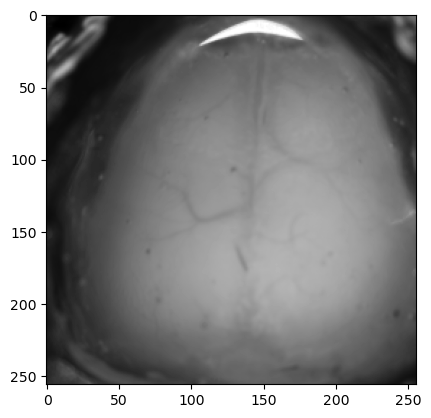

In [3]:
'''
Step2, bin frame into 5Hz, as it's captured in 30Hz, we bin 6 graph to 1.
'''
_,height,width = raw_r_series.shape
bin_time = 6
binned_num = len(raw_r_series)//bin_time # we bin 30 to 5, average every 6 frame
binned_r_series = raw_r_series[:binned_num*bin_time,:,:].reshape(binned_num,bin_time,height,width)
binned_r_series = binned_r_series.mean(1).astype('u2')# Transfer data into 'uint16' data format.

# example of all averaged graph
print(binned_r_series.shape)
avr_graph = binned_r_series.mean(0)
plt.imshow(avr_graph,cmap='gray')
np.save(cf.join(wp,'binned_r_series'),binned_r_series)

del raw_r_series


___
- Step3, align graph into standard space.    
***As some GUI problem, this step will only work on server remote-desktop.***    
The bin value here will determine the resolution of result graph.   
This step have 2 parts, fit and transfer.


After Align Resolution:330x285
Selecting Bregma..
Selecting Lambda..
Selecting Other Points..
Continuing with the process...
Select points saved in self.anchor


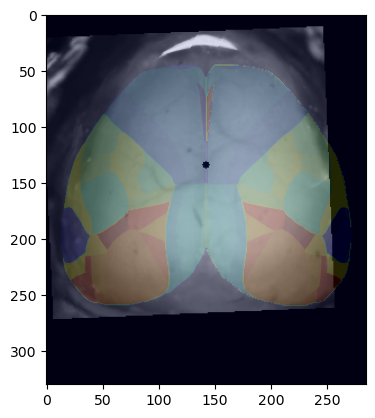

In [6]:
''' 
Step 3, align binned graph into standard space. This operation contains 2 parts:
    1. Fit transfer model
    2. Transfer data to standard space 
'''
from Align_Tools import Match_Pattern
# part 1, fit model of transformation
avr_graph = binned_r_series.mean(0)
MP = Match_Pattern(avr = avr_graph,bin=4,lbd=4.2) 
# lbd is lambda-bregma-distance, you can physically measure the distance between them to match it more accurately.
MP.Select_Anchor()
MP.Fit_Align_Matrix()

In [9]:
# part 2, if you are satisfied of result, transfer and save results. 

trans_series= MP.Transform_Series(stacks=binned_r_series,intra=cv2.INTER_NEAREST)
# intra parameter decide which method shall we intrapolate 


np.save(cf.join(wp,'Aligned_Series'),trans_series)
print(trans_series.shape)

# show average graph.
cv2.imwrite(cf.join(wp,'Average_After.png'),trans_series.mean(0).astype('u2'))

100%|██████████| 18013/18013 [01:44<00:00, 172.20it/s]


(18013, 330, 285)


True

___
- Step 4, generate dR/R and Z series.    
  Filter(or detrend) shall be done before drr.

100%|██████████| 330/330 [04:03<00:00,  1.36it/s]


(18013, 330, 285)


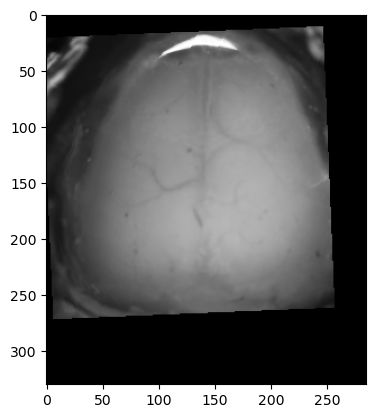

In [10]:
from Signal_Functions.Filters import Signal_Filter_1D
from scipy.ndimage import gaussian_filter

HP = 0.005 # High pass filter, in Hz
LP = 1 # Low pass filter, in Hz
fps = 5 # Capture frequency after bin, in Hz. For demo, we bin 30 into 5Hz.

# Filt each pix train.
img_num,height,width = trans_series.shape
filt_r_series = np.zeros(shape = (trans_series.shape),dtype = 'f8')
for i in tqdm(range(height)):# actually there are quicker ways, but I'm lazy.
    for j in range(width):
        c_series = trans_series[:,i,j]
        if c_series.sum() !=0: # ignore pix that is out of chamber.
            c_filt_series = Signal_Filter_1D(c_series,HP,LP,fps)# you can open this function to see what these parameters means.
            filt_r_series[:,i,j] = c_filt_series
print(filt_r_series.shape)
plt.imshow(filt_r_series.mean(0),cmap = 'gray')

- After filter, we can calculate dR/R and Z scored results.   
These vars are basic of more complex data processing, so I advise you save it.    
- **NOTICE: Raw values saved here, but clip shall be done before processing.**

In [11]:
# calculate dR/R.
# nan2num important, as all-0 series will lead to nan. This problem lead to warning too. Don't worry.
drr_series = np.nan_to_num((filt_r_series-filt_r_series.mean(0))/filt_r_series.mean(0)) 

# Z value supress blood-vessle pixel with high std.
z_series = np.nan_to_num(drr_series/drr_series.std(0))

# save raw data series, for further analysis, you will need clip or normalize.
print('Calculation finished, saving...')
np.save(cf.join(wp,'drr_series'),drr_series)
np.save(cf.join(wp,'z_series'),z_series)

# as you can see, effect of bv can be supressed easily by z value.
# NOTE that plotted data are CLIPPED.
# NOTE range of dRR and Z are different.
# NOTE pix out of chamber are VERY noisy.
fig,ax = plt.subplots(ncols=2,nrows=1,dpi = 180,figsize = (8,5))
sns.heatmap(z_series[700,:,:],center = 0,square = True,vmax = 1,vmin = -1,ax = ax[0],xticklabels=False,yticklabels=False,cbar=False)
sns.heatmap(drr_series[700,:,:],center = 0,square = True,vmax = 0.005,vmin = -0.005,ax = ax[1],xticklabels=False,yticklabels=False,cbar=False)
ax[0].set_title('Z Score')
ax[1].set_title(r'dR/R Score')


C:\Users\ZR\AppData\Local\Temp\ipykernel_35572\3575524411.py:3: RuntimeWarning: invalid value encountered in divide
  drr_series = np.nan_to_num((filt_r_series-filt_r_series.mean(0))/filt_r_series.mean(0))
C:\Users\ZR\AppData\Local\Temp\ipykernel_35572\3575524411.py:6: RuntimeWarning: invalid value encountered in divide
  z_series = np.nan_to_num(drr_series/drr_series.std(0))


Calculation finished, saving...



- Chamber mask is applied here.

{False, True}


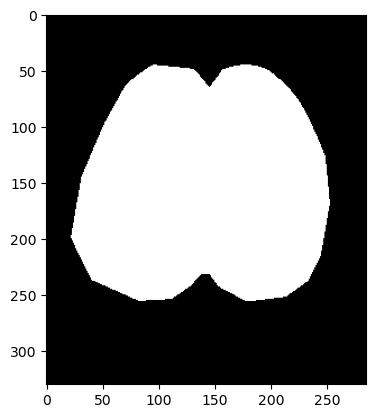

In [34]:
# load chamber mask.
# chamber mask is important for brain-area-wised data processing. Use Photoshop or GIMP(I prefer it!) to draw one.
mask = cv2.imread(cf.join(wp,'Chamber_mask.png'),0)>0
plt.imshow(mask,cmap='gray')
# dtype of mask shall be bool.
print(set(mask.flatten()))

- Codes below shows a example video of difference between dRR and Z.    
**Demo of how to generate a video are also shown here.**   
This function only accept uint 8 data.

In [35]:
# define a video writer function.
# this function can be used anywhere.
import skvideo.io

def Video_Plotter(series,savepath,filename,fps=15):
    # series here only accept uint 8 data type!
    if series.dtype != 'uint8':
        raise ValueError('Only uint 8 data type allowed.')
    
    fullpath = cf.join(savepath,filename)+'.avi'
    _,height,width = series.shape
    
    writer = skvideo.io.FFmpegWriter(fullpath, outputdict={
        '-vcodec': 'rawvideo',  #use the h.264 codec
        #  '-vcodec': 'libx264',
        '-crf': '0',           #set the constant rate factor to 0, which is lossless
        '-preset':'veryslow',   #the slower the better compression, in princple, 
        # '-r':str(fps), # this only control the output frame rate.
        '-pix_fmt': 'yuv420p',
        '-vf': "setpts=PTS*{},fps={}".format(25/fps,fps) , # I don't know why, but fps can only be set this way.
        '-s':'{}x{}'.format(width,height)
    }) 

    for frame in tqdm(series):
        # cv2.imshow('display',frame)
        writer.writeFrame(frame)  #write the frame as RGB not BGR
        # time.sleep(1/fps)

    writer.close() #close the writer
    cv2.destroyAllWindows()
    return True

In [37]:
# Clip and concate dRR and Z series of the same time
# Remember to add a chamber mask.
drr_clip = 0.005
z_clip = 1
series_A = np.clip(drr_series[3000:6000]*mask,-drr_clip,drr_clip)
series_B = np.clip(z_series[3000:6000]*mask,-z_clip,z_clip)

norm_series_A = series_A/max(series_A.max(),abs(series_A.min()))
plotable_A = (norm_series_A*127+127).astype('u1')
norm_series_B = series_B/max(series_B.max(),abs(series_B.min()))
plotable_B = (norm_series_B*127+127).astype('u1')
concat_series = np.concatenate((plotable_A,plotable_B),axis=2)

Video_Plotter(series = concat_series,savepath=wp,filename='drr_Z_compare',fps = 10) # 10 fps is 2x speed.
# we can see that Z series have less blood-vessel response. 
# NOTE:I Prefer Z series for less noise data.

100%|██████████| 3000/3000 [00:03<00:00, 880.80it/s] 


True

___
- Step 5, get response of brain area.    
I have packed function for it. You can use it for pattern recognition.
- Before this procedure, you will need clip and chamber masking for data.

In [38]:
from Atlas_Corr_Tools import Atlas_Data_Tools
series = np.clip(z_series,-3,3)*mask

# just load series into class.
ADT = Atlas_Data_Tools(series=series,bin=4,min_pix=30)
# brain area less than min_pix will be ignored.

# calculate brain area response.
ADT.Get_All_Area_Response()
# Variable of all area's response are saved in var below.
Area_Response = ADT.Area_Response
Area_Response

Calculating All Brain Area Response...


31it [00:19,  1.59it/s]


,Area,Function,LR,pixnum,Series
0,VISrl,Visual,L,424,"[0.7737181873149996, -0.18931818260367056, -0...."
1,VISpm,Visual,L,532,"[0.7600872641701828, 0.38138167729012523, 0.11..."
2,VISp,Visual,L,2295,"[0.7843127621053535, 0.3689252113988847, 0.054..."
3,VISli,Visual,L,97,"[0.7837999296792979, 0.08376490339222807, -0.4..."
4,VISl,Visual,L,316,"[0.7900920340105906, 0.12549241344040826, -0.3..."
5,VISam,Visual,L,351,"[0.8653680237652146, 0.36757974339999216, 0.07..."
6,VISal,Visual,L,285,"[0.7020584274317496, -0.28483946831730206, -0...."
7,VISa,Visual,L,617,"[0.9007009555600751, 0.3191670611211195, -0.01..."
8,SSs,Somatosensory,L,334,"[0.6545646480503272, -0.6106073904318748, -1.3..."
9,SSp-un,Somatosensory,L,361,"[0.5946654040884011, -0.37249234985510515, -0...."


👆 Notice! brain areas here have already been sorted.    
This class also provide you a tool to get response heatmap directly.


Combining Heatmap of Brain Area Response...


100%|██████████| 51/51 [00:00<00:00, 77.40it/s] 


[Text(0, 0.5, 'VISrl_L'),
 Text(0, 1.5, 'VISpm_L'),
 Text(0, 2.5, 'VISp_L'),
 Text(0, 3.5, 'VISli_L'),
 Text(0, 4.5, 'VISl_L'),
 Text(0, 5.5, 'VISam_L'),
 Text(0, 6.5, 'VISal_L'),
 Text(0, 7.5, 'VISa_L'),
 Text(0, 8.5, 'SSs_L'),
 Text(0, 9.5, 'SSp-un_L'),
 Text(0, 10.5, 'SSp-ul_L'),
 Text(0, 11.5, 'SSp-tr_L'),
 Text(0, 12.5, 'SSp-n_L'),
 Text(0, 13.5, 'SSp-m_L'),
 Text(0, 14.5, 'SSp-ll_L'),
 Text(0, 15.5, 'SSp-bfd_L'),
 Text(0, 16.5, 'RSPv_L'),
 Text(0, 17.5, 'RSPd_L'),
 Text(0, 18.5, 'RSPagl_L'),
 Text(0, 19.5, 'TEa_L'),
 Text(0, 20.5, 'PL_L'),
 Text(0, 21.5, 'FRP_L'),
 Text(0, 22.5, 'ACAd_L'),
 Text(0, 23.5, 'MOs_L'),
 Text(0, 24.5, 'MOp_L'),
 Text(0, 25.5, 'AUDpo_L'),
 Text(0, 26.5, 'AUDp_L'),
 Text(0, 27.5, 'AUDd_L'),
 Text(0, 28.5, 'MOp_R'),
 Text(0, 29.5, 'MOs_R'),
 Text(0, 30.5, 'ACAd_R'),
 Text(0, 31.5, 'FRP_R'),
 Text(0, 32.5, 'PL_R'),
 Text(0, 33.5, 'RSPagl_R'),
 Text(0, 34.5, 'RSPd_R'),
 Text(0, 35.5, 'RSPv_R'),
 Text(0, 36.5, 'SSp-bfd_R'),
 Text(0, 37.5, 'SSp-ll_R'),
 Text(

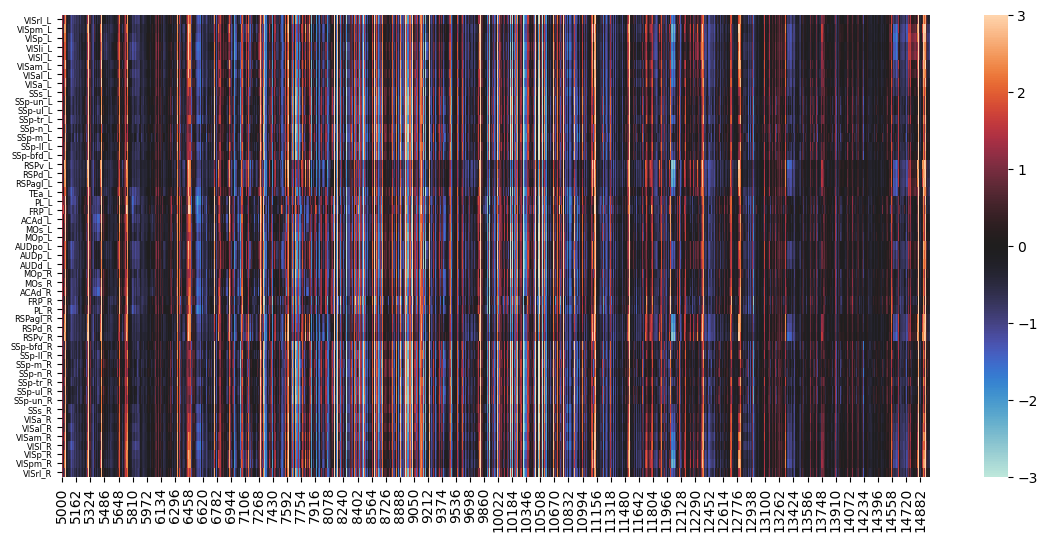

In [71]:
# the heatmap are in pandas format.
# NOTE: Name of brain area is combined, so it's a little different from response above.
Area_Response_Heatmap = ADT.Combine_Response_Heatmap()

fig,ax = plt.subplots(ncols=1,nrows=1,figsize = (14,6))
sns.heatmap(Area_Response_Heatmap.iloc[:,5000:15000],center = 0,ax = ax,yticklabels=False)# 10000 frame is about 2000s

# here is a way to show full brain area name. It's quite fuzzy = = 
# If you want to see it briefly, none below is required.
ax.set_yticks(np.array(range(len(Area_Response_Heatmap.index)))+0.5)
ax.set_yticklabels(list(Area_Response_Heatmap.index),size = 6)


👆 As you can see, most brain area active in a synchronized way.    
RSP's response is a little different from others, this might because BV here are very big.   
    
*If you contain BV mask in chamber mask, this problem might can be solved.*    
    
**And state change is directly visible from heatmap. If compared with pupil or motion, more analysis is possible.**

- Save variables that might be useful in the future.    
You can save the whole class directly, but as series is already loaded into the class, this will cost you more HD space.   
I recommend you save only the vars you need.

In [72]:
# save vars.
cf.Save_Variable(wp,'Area_Response',Area_Response)
cf.Save_Variable(wp,'Area_Response_Heatmap',Area_Response_Heatmap)


True